- PostgreSQL의 동시성 제어 메커니즘에는 다음과 같은 유지 관리 프로세스가 필요.

1. 해당 데드 튜플을 가리키는 데드 튜플과 인덱스 튜플을 제거.
2. 막힘의 불필요한 부분을 제거.
3. 오래된 txid를 동결.
4. FSM, VM 및 통계를 업데이트.

- 세 번째 프로세스는 트랜잭션 ID 랩어라운드 문제와 관련.

- PostgreSQL에서는 VACUUM 처리가 이러한 프로세스를 담당

**FREEZE Processing**

- txid 랩어라운드 문제에 대해 설명.

- Tuple_1 튜플이 txid 100으로 삽입되었다고 가정.
  - 즉, Tuple_1의 t_xmin이 100.

1. 서버가 매우 오랫동안 실행되어 왔으며 Tuple_1은 수정되지 않음.
2. 현재 txid는 21억 + 100이고 SELECT 명령이 실행됨.
3. 이때 txid 100이 과거이기 때문에 Tuple_1이 보임 .
4. 그런 다음 동일한 SELECT 명령이 실행됨.
5. 따라서 현재 txid는 21억 + 101.
6. 그러나 txid 100이 미래이기 때문에 Tuple_1은 더 이상 표시되지 않음

- 이것이 PostgreSQL의 소위 트랜잭션 랩어라운드 문제.



**Wraparound problem.**

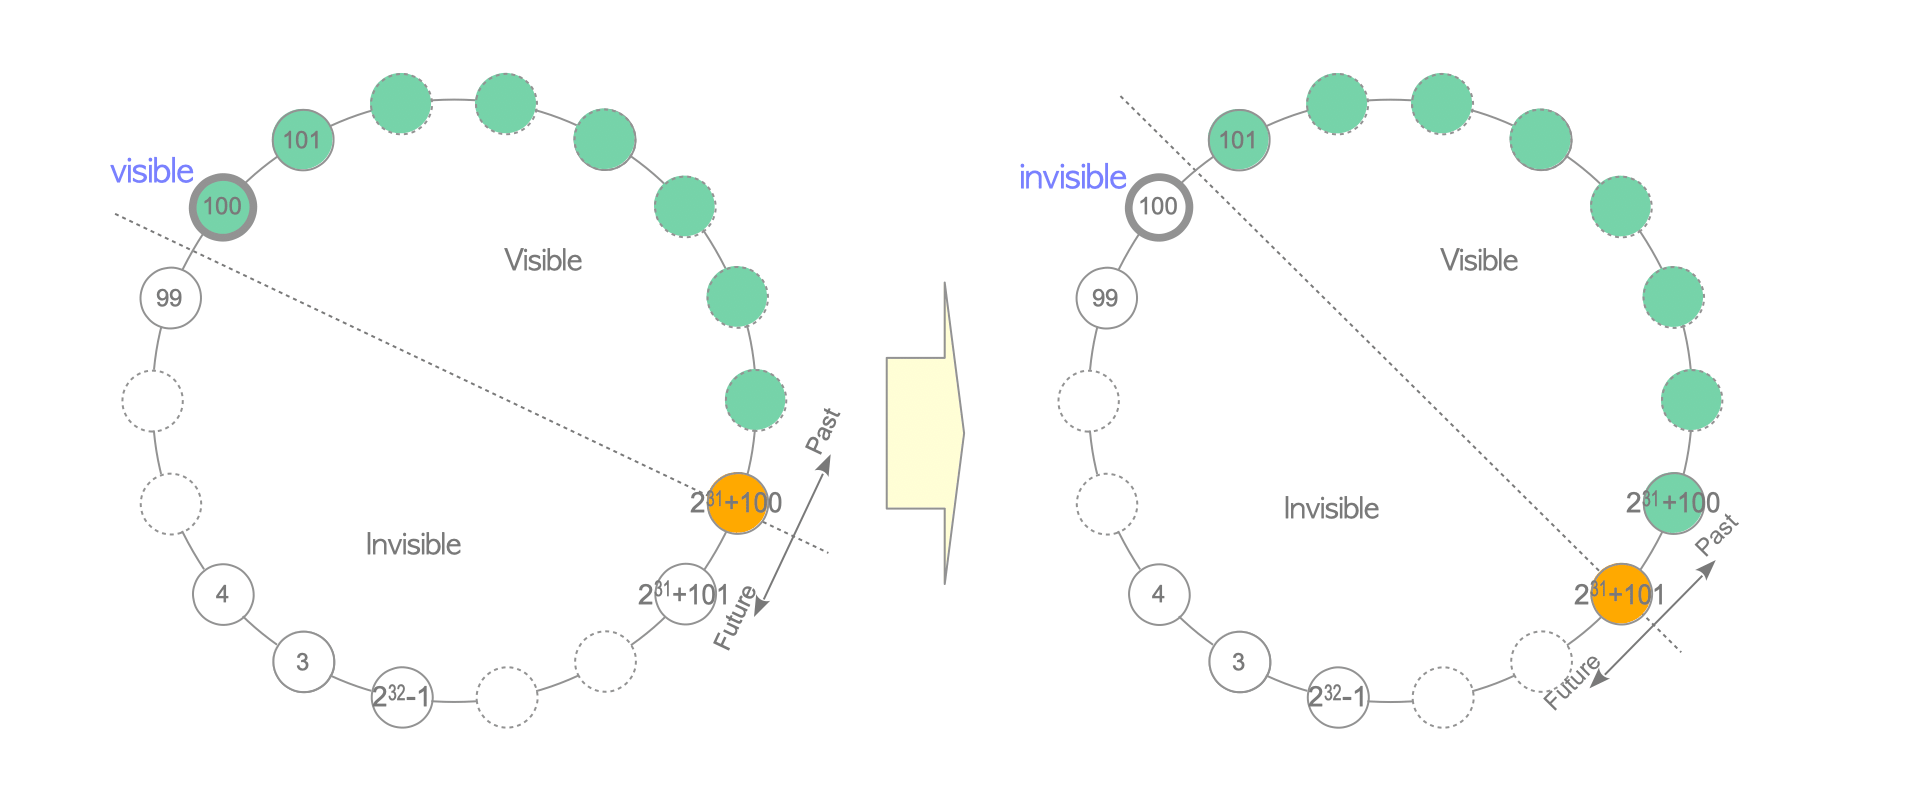

- 이 문제를 해결하기 위해 PostgreSQL은 Frozen txid 라는 개념을 도입 하고 FREEZE 라는 프로세스를 구현

- PostgreSQL에서는 특별히 예약된 txid 2인 고정 txid가 항상 다른 모든 txid보다 오래되도록 정의됨.
  - 즉, 고정된 txid는 항상 비활성 상태이고 표시.

- 동결 프로세스는 진공 프로세스에 의해 호출됨.
  - 동결 프로세스는 모든 테이블 파일을 스캔하고 t_xmin 값이 현재 txid에서 Vacuum_freeze_min_age를 뺀 값 ( 기본값은 5천만)보다 오래된 경우 튜플의 t_xmin을 동결된 txid(2)에 다시 씀.

- 예를 들어 그림에서 볼 수 있듯이 현재 txid는 5천만이고 고정 프로세스는 VACUUM 명령에 의해 호출됨.
  - 이 경우 Tuple_1과 Tuple_2의 t_xmin은 모두 2로 다시 작성됨.

- 버전 9.4 이상에서는 튜플의 t_xmin을 고정된 txid에 다시 쓰는 대신 XMIN_FROZEN 비트가 튜플의 t_infomask 필드로 설정됨.

**Freeze process.**

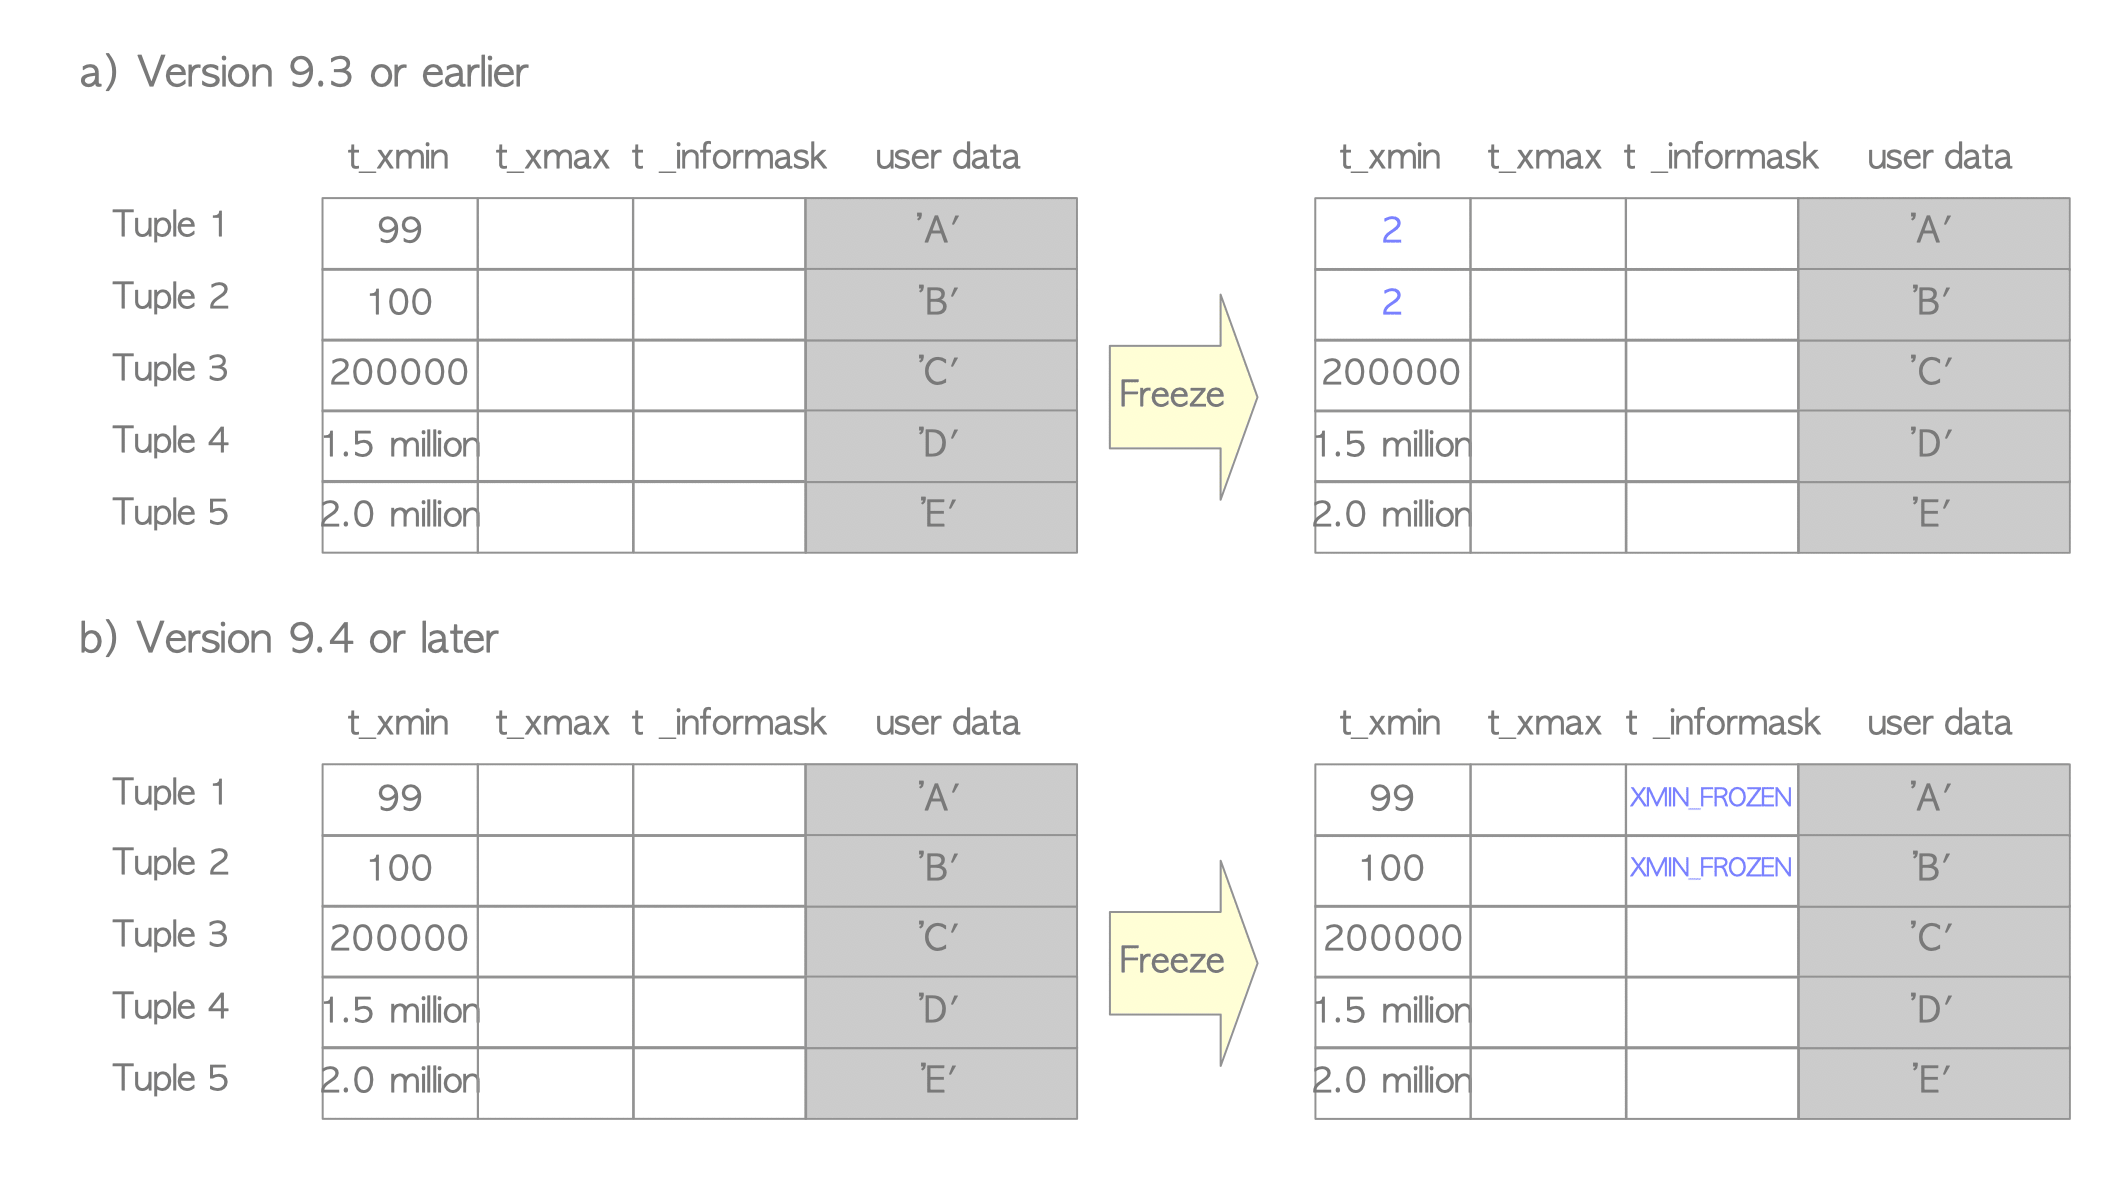